# Анализ поведения пользователей приложения для покупки продуктов питания.

## Описание проекта.

Необходимо изучить поведение пользователей в мобильном приложении-стартапе, которое продаёт продукты питания. 
Важно узнать путь пользователя к покупке и возможные проблемы.

Кроме того, нужно проверить, как может повлиять на пользователей новый шрифт в приложении. Не будет ли шрифт мешать пользователям и усложнять их взаимодействие с приложением.

## Задачи проекта. 

- Изучить воронку продаж. 
- Исследовать результаты A/A/B-эксперимента.
- Сделать выводы и дать рекомендации. 

## План исследования. 

1. Загрузить данные и подготовь их к анализу.
2. Проанализировать записи о событиях.
3. Создать и изучить воронку событий.
4. Проверить собранные данные по результатам A/A/B-эксперимента на валидность.
5. Проанализировать результаты A/A/B-эксперимента. 
6. Проверить результаты A/A/B-эксперимента с разными уровнями значимости.
7. Сделать выводы и дать рекомендации.

In [1]:
# импортируем библиотеки
import pandas as pd
from scipy import stats as st
import datetime as dt
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns
import plotly.express as px
import math as mth

## 1. Загрузка и подготовка данных. 

In [2]:
# загружаем файлы
events = pd.read_csv('C:/Users/dnast/Downloads/Сборный проект-2/logs_exp.csv', sep='\t')

In [3]:
# создаём функцию для проверки данных в файлах

def analyze_file(df):
     # описание данных
    description = df.describe()

    # анализ наиболее часто встречающихся строк с помощью value_counts
    most_frequent_rows = df.apply(tuple, axis=1).value_counts().reset_index()
    most_frequent_rows.columns = ['Строка', 'Частота']

    # первые несколько строк
    first_few_rows = df.head()

    # обзор данных
    data_info = df.info()

    print('*' * 50)  

    return {
        'first_few_rows': first_few_rows,
        'description': description,
        'most_frequent_rows': most_frequent_rows,
        'data_info': data_info
    }


In [4]:
# проверяем данные
analyze_file(events)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB
**************************************************


{'first_few_rows':                  EventName         DeviceIDHash  EventTimestamp  ExpId
 0         MainScreenAppear  4575588528974610257      1564029816    246
 1         MainScreenAppear  7416695313311560658      1564053102    246
 2  PaymentScreenSuccessful  3518123091307005509      1564054127    248
 3         CartScreenAppear  3518123091307005509      1564054127    248
 4  PaymentScreenSuccessful  6217807653094995999      1564055322    248,
 'description':        DeviceIDHash  EventTimestamp          ExpId
 count  2.441260e+05    2.441260e+05  244126.000000
 mean   4.627568e+18    1.564914e+09     247.022296
 std    2.642425e+18    1.771343e+05       0.824434
 min    6.888747e+15    1.564030e+09     246.000000
 25%    2.372212e+18    1.564757e+09     246.000000
 50%    4.623192e+18    1.564919e+09     247.000000
 75%    6.932517e+18    1.565075e+09     248.000000
 max    9.222603e+18    1.565213e+09     248.000000,
 'most_frequent_rows':                                           

In [5]:
# приводим названия колонок к виду согласно pep8
events.rename(columns={
    'EventName': 'event_name',
    'DeviceIDHash': 'device_id_hash',
    'EventTimestamp': 'event_timestamp',
    'ExpId': 'exp_id'
}, inplace=True)

In [6]:
# выводим уникальные значения в колонке event_name, чтобы проверить неявные дубликаты и корректность написания
events.event_name.unique()

array(['MainScreenAppear', 'PaymentScreenSuccessful', 'CartScreenAppear',
       'OffersScreenAppear', 'Tutorial'], dtype=object)

In [7]:
# создаём словать со старыми и новыми значениями event_name согласно pep8
event_name_pep8 = {
    'MainScreenAppear': 'main_screen_appear',
    'PaymentScreenSuccessful': 'payment_screen_successful',
    'CartScreenAppear': 'cart_screen_appear',
    'OffersScreenAppear': 'offers_screen_appear',
    'Tutorial': 'tutorial'
}

# меняем названия мероприятий в колонке event_name согласно pep8
events['event_name'] = events['event_name'].replace(event_name_pep8)

In [8]:
# меняем формат колонки со временем в формате Unix на datetime 
events['event_timestamp'] = pd.to_datetime(events['event_timestamp'], unit='s')

In [9]:
# видим, что есть явные дубликаты. Проверяем их процент от общего количества строк
f'Процент явных дубликатов: {round((events.duplicated().sum()/len(events))*100, 2)}'

'Процент явных дубликатов: 0.17'

In [10]:
# удаляем явные дубликаты
events.drop_duplicates(inplace=True)

In [11]:
# проверяем данные
analyze_file(events)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 243713 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   event_name       243713 non-null  object        
 1   device_id_hash   243713 non-null  int64         
 2   event_timestamp  243713 non-null  datetime64[ns]
 3   exp_id           243713 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 9.3+ MB
**************************************************


{'first_few_rows':                   event_name       device_id_hash     event_timestamp  exp_id
 0         main_screen_appear  4575588528974610257 2019-07-25 04:43:36     246
 1         main_screen_appear  7416695313311560658 2019-07-25 11:11:42     246
 2  payment_screen_successful  3518123091307005509 2019-07-25 11:28:47     248
 3         cart_screen_appear  3518123091307005509 2019-07-25 11:28:47     248
 4  payment_screen_successful  6217807653094995999 2019-07-25 11:48:42     248,
 'description':        device_id_hash         exp_id
 count    2.437130e+05  243713.000000
 mean     4.627963e+18     247.022161
 std      2.642723e+18       0.824420
 min      6.888747e+15     246.000000
 25%      2.372212e+18     246.000000
 50%      4.623192e+18     247.000000
 75%      6.932517e+18     248.000000
 max      9.222603e+18     248.000000,
 'most_frequent_rows':                                                    Строка  Частота
 0       (main_screen_appear, 4575588528974610257, 2019... 

**В датасете**: 
- данные были записаны через "/" - для удобного разделения в код прочтения добавлено разделение пропуском;
- пропусков нет;
- 0,17% явных дубликатов удалено;
- названия приведены к pep8;
- форматы данных в столбцах корректные, кроме времени. Кроме того, время записано в формате Unix. Формат заменён на datetime. 

In [12]:
# столбец даты и времени уже есть, добавляем отдельный столбец дат
events['date'] = events['event_timestamp'].dt.date

In [13]:
# проверка
events['date'].head()

0    2019-07-25
1    2019-07-25
2    2019-07-25
3    2019-07-25
4    2019-07-25
Name: date, dtype: object

**Вывод:** столбец с датой добавлен.

## 2. Изучение данных.

### 2.1. Количество событий в логе.

In [14]:
# подсчёт количества событий в логе
events_total=len(events)
f'Всего в логе событий: {events_total}'

'Всего в логе событий: 243713'

### 2.2. Количество пользователей в логе.

In [15]:
# подсчёт количества уникальных пользователей
events_users_total=events.device_id_hash.nunique()
f'Всего в логе уникальных пользователей: {events_users_total}'

'Всего в логе уникальных пользователей: 7551'

### 2.3. Среднее количество событий на пользователя.

In [16]:
# группируем данные по пользователю и считаем количество событий 
event_counts = events.groupby('device_id_hash')['event_name'].count().reset_index()

# задаём колонки
event_counts.columns = ['device_id_hash', 'events_number']

# вывод
event_counts.head()

,device_id_hash,events_number
0,6888746892508752,1
1,6909561520679493,5
2,6922444491712477,47
3,7435777799948366,6
4,7702139951469979,137


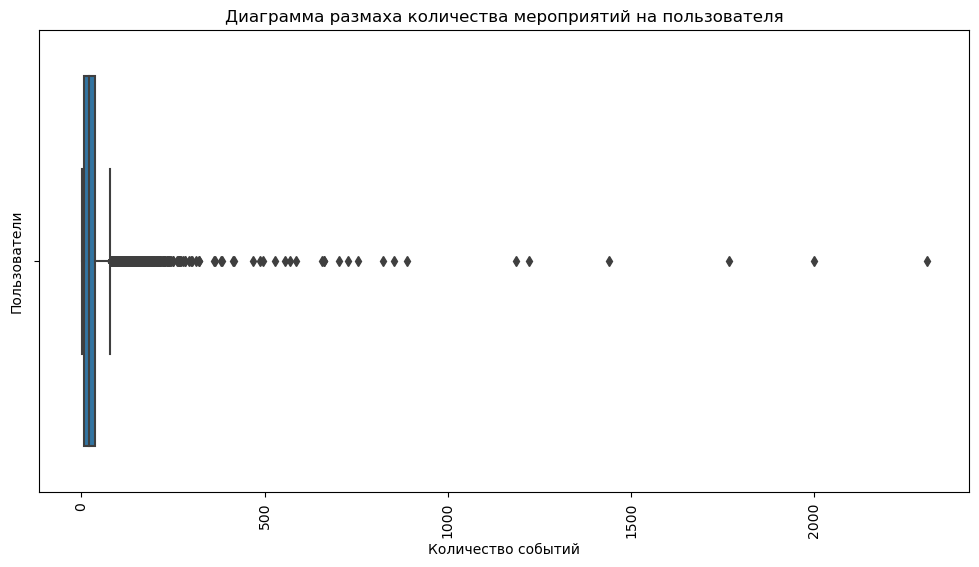

In [17]:
# задаём размеры графика
plt.figure(figsize=(12, 6))  

# задаём данные для построения графика
sns.boxplot(x='events_number', data=event_counts)
plt.xlabel('Количество событий')
plt.ylabel('Пользователи')
plt.title('Диаграмма размаха количества мероприятий на пользователя')

# разворачиваем график для читабельности
plt.xticks(rotation=90) 

plt.show()

**На диаграмме размаха видно, что за пределами максимума (за "усами" ящика) много выбросов. Медиана находится в пределах меньше 50 мероприятий на человека. При этом аномальные значения достигают более 2000. В этом случае смотрим медиану.**

In [18]:
# считаем медиану количества событий на пользователя
event_counts['events_number'].median()

20.0

**Медианное количество событий на пользователя - 20.**

### 2.3. Анализ периода предоставленных данных.

In [19]:
f'Данные в логе за период с {events.date.min()} по {events.date.max()}'

'Данные в логе за период с 2019-07-25 по 2019-08-07'

In [20]:
# строим сводную таблицу, группируем по дате и эксперименту, считаем события
pivot_table = events.pivot_table(index=['date', 'exp_id'], values='event_name', aggfunc='count')

# сбрасываем индексы, чтобы сделать 'date' и 'exp_id' обычными названиями колонок
pivot_table = pivot_table.reset_index()

# даём названия колонкам
pivot_table.columns = ['date', 'exp_id', 'events_number']

# вывод таблицы 
pivot_table

,date,exp_id,events_number
0,2019-07-25,246,4
1,2019-07-25,247,1
2,2019-07-25,248,4
3,2019-07-26,246,14
4,2019-07-26,247,8
5,2019-07-26,248,9
6,2019-07-27,246,24
7,2019-07-27,247,23
8,2019-07-27,248,8
9,2019-07-28,246,33


In [21]:
# делаем новую сводную таблицу, чтобы сделать значения 'exp_id' названиями колонок
final_pivot = pivot_table.pivot(index='date', columns='exp_id', values='events_number')

# сбрасываем названия колонок
final_pivot.columns.name = None

# задаём названия колонок
final_pivot = final_pivot.rename_axis(None, axis=1)
final_pivot = final_pivot.reset_index()
final_pivot.columns = ['date', 'exp_246', 'exp_247', 'exp_248']

# выводим таблицу на экран
final_pivot

,date,exp_246,exp_247,exp_248
0,2019-07-25,4,1,4
1,2019-07-26,14,8,9
2,2019-07-27,24,23,8
3,2019-07-28,33,36,36
4,2019-07-29,55,58,71
5,2019-07-30,129,138,145
6,2019-07-31,620,664,746
7,2019-08-01,11561,12306,12274
8,2019-08-02,10946,10990,13618
9,2019-08-03,10575,11024,11683


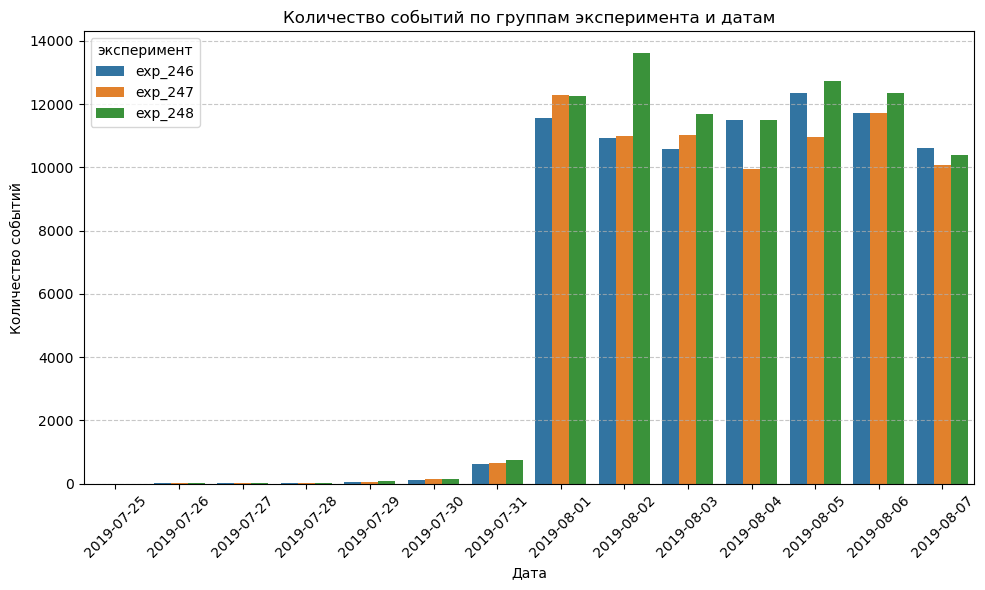

In [22]:
# преобразовываем таблицу для графика
final_pivot_long = pd.melt(final_pivot, id_vars=['date'], value_vars=['exp_246', 'exp_247', 'exp_248'], var_name='эксперимент')

# создаём столбчатую диаграмму
plt.figure(figsize=(10, 6))  
sns.barplot(x='date', y='value', hue='эксперимент', data=final_pivot_long)
plt.title('Количество событий по группам эксперимента и датам')
plt.xlabel('Дата')
plt.ylabel('Количество событий')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# разворачиваем даты для читабельности
plt.xticks(rotation=45)  

plt.tight_layout()
plt.show()

**Данные представлены с 25 июля по 7 августа, но по факту до 1 августа данных почти нет (событий от нескольких единиц до максимум нескольких сотен по группам). С 1го же августа количество событий по группам от примерно 9 тыс. до примерно 14 тыс.), поэтому мы можем оценивать результаты теста по данным в период с 1 августа 2019 по 07 августа 2019.**

In [23]:
# конвертируем дату
date_threshold = pd.to_datetime('2019-08-01').date()  

# фильтруем датафрейм
events_full = events.loc[events['date'] >= date_threshold]

In [24]:
f'Данные в логе за период с {events_full.date.min()} по {events_full.date.max()}'

'Данные в логе за период с 2019-08-01 по 2019-08-07'

In [25]:
# подсчёт количества событий за обрезанный период
events_full_total=len(events_full)
f'Всего в логе событий: {events_full_total}'

'Всего в логе событий: 240887'

In [26]:
# подсчёт процентра "отрезанных" событий
f'Всего "отрезано" событий: {round((1-(events_full_total/events_total))*100, 2)}%'

'Всего "отрезано" событий: 1.16%'

In [27]:
# подсчёт количества уникальных пользователей за обрезанный период
events_full_users_total=events_full.device_id_hash.nunique()
f'Всего в логе уникальных пользователей (после сокращения периода): {events_full_users_total}'

'Всего в логе уникальных пользователей (после сокращения периода): 7534'

In [28]:
# подсчёт процентра "отрезанных" пользователей
f'Всего "отрезано" пользователей: {round((1-(events_full_users_total/events_users_total))*100, 2)}%'

'Всего "отрезано" пользователей: 0.23%'

**Был создан новый датасет с периодом проведения экспериментов 1-7 августа 2019 года. В датасете более 240 тыс. событий и более 7,5 тыс. пользователей. При удалении данных за период 25-31 июля 2019 года было утеряно 1,16% событий и 0,23% пользователей, что незначительно для корретной интерпретации экспериментов.**

### 2.4. Проверка наличия выборок для всех трёх групп эксперимента.

In [29]:
# создаём сводную таблицу с пользователями по группам
users_by_exp = events_full.pivot_table(index='exp_id', values='device_id_hash', aggfunc='nunique')

# сбрасываем индексы
users_by_exp = users_by_exp.reset_index()

# даём названия колонкам
users_by_exp.columns = ['exp_id', 'users_number']

users_by_exp

,exp_id,users_number
0,246,2484
1,247,2513
2,248,2537


**В каждой группе эксперимента достаточное количество пользователей практически на одинаковом уровне (около 2500 пользователей).**

## 3. Анализ воронки событий.

### 3.1. Изучение событий в логах, как часто они встречаются. Сортировка событий по частоте.

In [30]:
# создаём сводную таблицу по названиям мероприятий и их частоте
events_frequency = events_full.pivot_table(index='event_name', values='device_id_hash', aggfunc='count').sort_values(
    by='device_id_hash', ascending = False)

# сбрасываем индексы
events_frequency = events_frequency.reset_index()

# даём названия колонкам
events_frequency.columns = ['event_name', 'events_number']

events_frequency

,event_name,events_number
0,main_screen_appear,117328
1,offers_screen_appear,46333
2,cart_screen_appear,42303
3,payment_screen_successful,33918
4,tutorial,1005


In [31]:
# проверка
if sum(events_frequency['events_number']) == events_full_total:
    print('Частота событий посчитана верно.')
else:
     print('В расчёте частоты событий ошибка.')   

Частота событий посчитана верно.


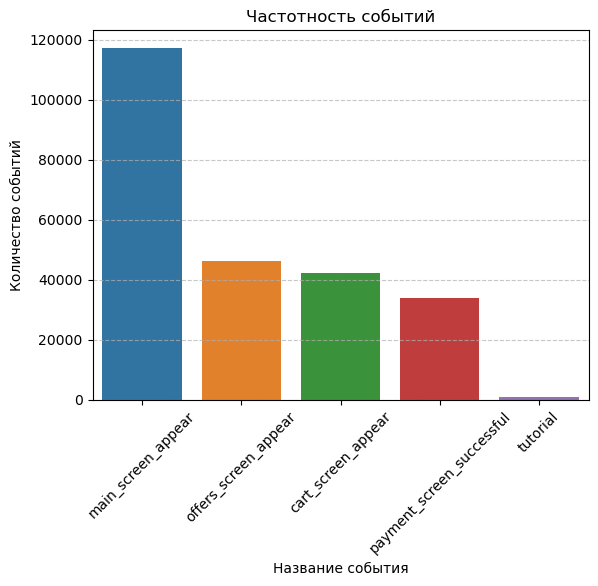

In [32]:
# строим график частотности событий
sns.barplot(x='event_name', y='events_number', data=events_frequency)

plt.title('Частотность событий')
plt.xlabel('Название события')
plt.ylabel('Количество событий')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# разворачиваем события для читабельности
plt.xticks(rotation=45);  

**Частотность событий по данным экспериментов следующая:** 

1. Показ основного экрана - более 117 тыс.
2. Показ предложений - более 46 тыс. 
3. Показ страницы с корзиной - более 42 тыс. 
4. Показ страницы с успешной оплатой - почти 34 тыс.
5. Инструкции - чуть больше 1 тыс.

Позже рассмотрим их в качестве воронки событий.

### 3.2. Расчёт количества пользователей, которые совершали каждое из этих событий. Сортировка события по числу пользователей. Расчёт доли пользователей, которые хоть раз совершали событие.

In [33]:
# создаём сводную таблицу по названиям мероприятий и количеству пользователей, которые совершали каждое событие
events_users_frequency = events_full.pivot_table(index='event_name', values='device_id_hash', aggfunc='nunique').sort_values(
    by='device_id_hash', ascending = False)

# сбрасываем индексы
events_users_frequency = events_users_frequency.reset_index()

# даём названия колонкам
events_users_frequency.columns = ['event_name', 'users_number']

events_users_frequency

,event_name,users_number
0,main_screen_appear,7419
1,offers_screen_appear,4593
2,cart_screen_appear,3734
3,payment_screen_successful,3539
4,tutorial,840


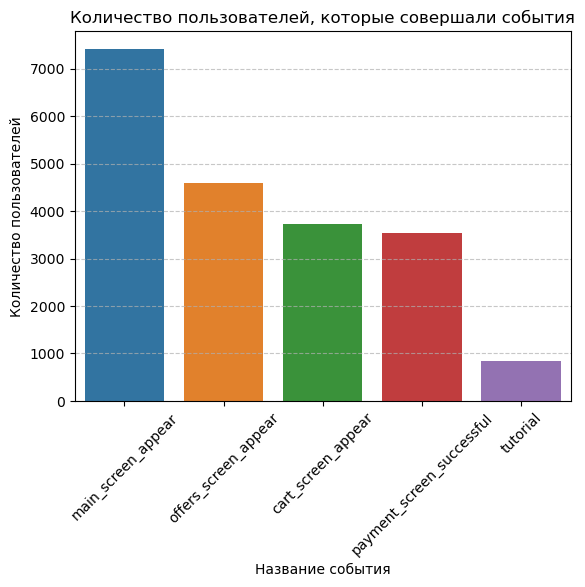

In [34]:
# строим график количества пользователей по событиям
sns.barplot(x='event_name', y='users_number', data=events_users_frequency)

plt.title('Количество пользователей, которые совершали события')
plt.xlabel('Название события')
plt.ylabel('Количество пользователей')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# разворачиваем события для читабельности
plt.xticks(rotation=45);  

**Рейтинг событий по количеству пользователей следующий:** 

1. Показ основного экрана - более 7 тыс.
2. Показ предложений - более 4,5 тыс. 
3. Показ страницы с корзиной - более 3,7 тыс. 
4. Показ страницы с успешной оплатой - почти 3,5 тыс.
5. Инструкции - 840

Рейтинг полностью совпадает по местам с рейтингом частотности событий. Противоречий в анализе пока нет.

In [35]:
# считаем пропорции для кажого события воронки
events_users_frequency['proportion'] = round(events_users_frequency['users_number']/events_full_users_total*100, 4)

In [36]:
events_users_frequency

,event_name,users_number,proportion
0,main_screen_appear,7419,98.4736
1,offers_screen_appear,4593,60.9636
2,cart_screen_appear,3734,49.5620
3,payment_screen_successful,3539,46.9737
4,tutorial,840,11.1495


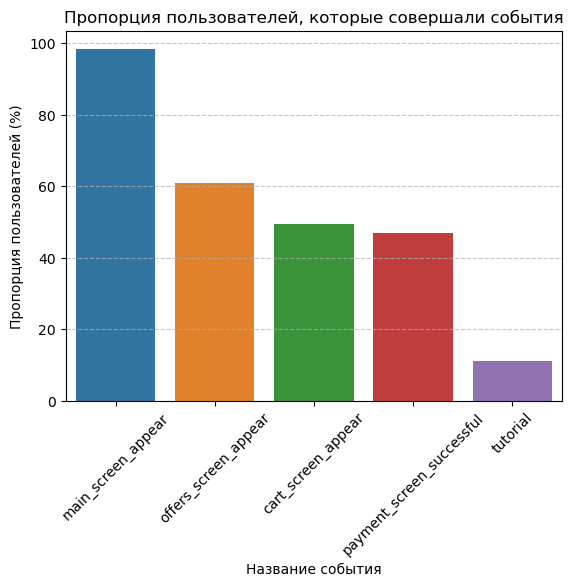

In [37]:
# строим график доли пользователей от общего количества пользователей по событиям
sns.barplot(x='event_name', y='proportion', data=events_users_frequency)

plt.title('Пропорция пользователей, которые совершали события')
plt.xlabel('Название события')
plt.ylabel('Пропорция пользователей (%)')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# разворачиваем события для читабельности
plt.xticks(rotation=45);  

**Согласно рейтингу событий по пропорциям, места событий не изменились:**
        
        - Почти 100% пользователей смотрят главный экран. 
        - 60% от всех пользователей смотрят экран с предложениями.
        - 50% - попадают в корзину. 
        - 47% - видят экран успешной оплаты.
        - 11% - смотрят инструкцию.

### 3.3. Построение порядка событий. Выявление событий, которые не входят в последовательность и не должны быть в расчётах воронки.

Порядок событий пользователя следующий (и это же показывают графики, так как пользователи и события уменьшаются с каждым шагом): 

1. Показ основного экрана - более 7 тыс.
2. Показ предложений - более 4,5 тыс.
3. Показ страницы с корзиной - более 3,7 тыс.
4. Показ страницы с успешной оплатой - почти 3,5 тыс.

Убираем только событие "Инструкция", потому что оно не связано с остальными событиями (может быть после любого шага), поэтому его не нужно включать в воронку для анализа.

In [38]:
# создаём таблицу с воронкой событий
events_funnel = events_users_frequency[events_users_frequency['event_name'] != 'tutorial']
events_funnel

,event_name,users_number,proportion
0,main_screen_appear,7419,98.4736
1,offers_screen_appear,4593,60.9636
2,cart_screen_appear,3734,49.5620
3,payment_screen_successful,3539,46.9737


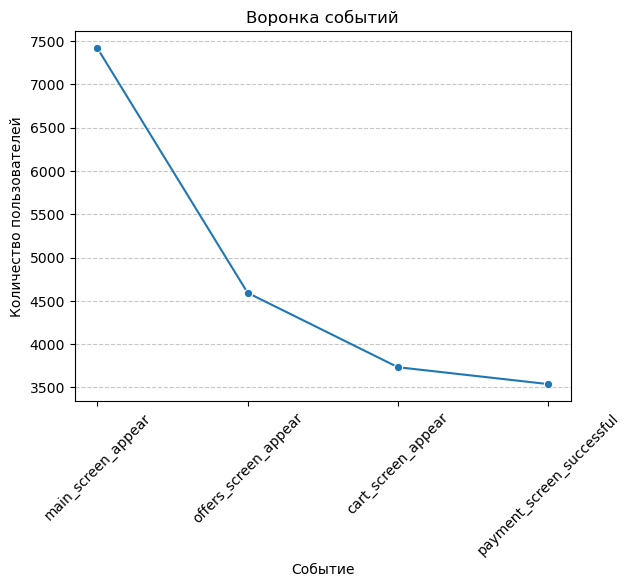

In [39]:
# строим линейный график количества пользователей по событиям
sns.lineplot(x='event_name', y='users_number', data=events_funnel, marker='o')

plt.title('Воронка событий')
plt.xlabel('Событие')
plt.ylabel('Количество пользователей')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# разворачиваем события для читабельности
plt.xticks(rotation=45)

plt.show()

**На графике видно существенное снижение количества пользователей с шага "Показ основного экрана" до "Показ предложений". Далее между шагами также идёт снижение по пользователям, но уже не такое большое.**

### 3.4. Расчёт доли пользователей на каждом шаге воронки (от числа пользователей на предыдущем). Выявление шага, на котором теряется больше всего пользователей. 

In [40]:
# избавляемся от ложноположительного оповещения SettingWithCopyWarning (возникло на моём ПК)
pd.options.mode.chained_assignment = None

# считаем долю пользователей от предыдущего шага
events_funnel['proportion'] = events_funnel['users_number'] / events_funnel['users_number'].shift(1)

# заменяем NaN на первом шаге на 1, так как до этого не было шага для сравнения
events_funnel['proportion'].fillna(1, inplace=True)

# округляем значения
events_funnel['proportion'] = events_funnel['proportion'].round(1)

# переводим значения в проценты
events_funnel['proportion'] = events_funnel['proportion'] * 100

# вывод таблицы
events_funnel

,event_name,users_number,proportion
0,main_screen_appear,7419,100.0
1,offers_screen_appear,4593,60.0
2,cart_screen_appear,3734,80.0
3,payment_screen_successful,3539,90.0


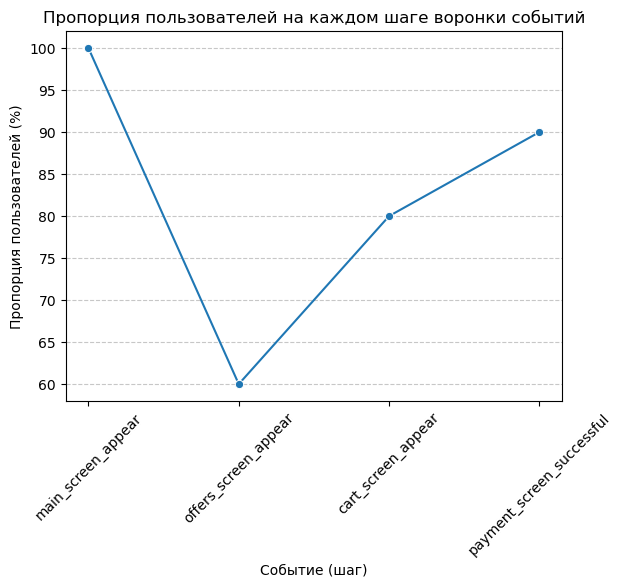

In [41]:
# создаём линейный график
sns.lineplot(x='event_name', y='proportion', data=events_funnel, marker='o')

plt.title('Пропорция пользователей на каждом шаге воронки событий')
plt.xlabel('Событие (шаг)')
plt.ylabel('Пропорция пользователей (%)')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# разворачиваем названия мероприятий для читабельности
plt.xticks(rotation=45)

plt.show()


**На графике пропорций пользователей по сравнению с предыдущим шагом также видно серьёзное падение с шага "Показ основного экрана" до "Показ предложений" (на втором шаге пользователей на 40% меньше, чем было на первом).** 

**Но далее мы видим рост пропорций по шагам:**

- на шаге "Показ страницы с корзиной" осталось 80% пользователей, которые были на предыдущем шаге "Показ предложений",
- на шаге "Показ страницы с успешной оплатой" осталось 90% пользователей, которые были на предыдущем шаге "Показ страницы с корзиной".

**Таким образом, больше всего теряется на шаге "Показ предложений".**

### 3.5. Расчёт доли пользователей, которые доходит от первого события до оплаты.

In [42]:
# убираем из исходного датафрейма пользоватедей, смотревших инструкцию
users_from_funnel = events_full[events_full['event_name'] != 'tutorial']
users_from_funnel.head(3)

,event_name,device_id_hash,event_timestamp,exp_id,date
2829,main_screen_appear,3737462046622621720,2019-08-01 00:08:00,246,2019-08-01
2830,main_screen_appear,3737462046622621720,2019-08-01 00:08:55,246,2019-08-01
2831,offers_screen_appear,3737462046622621720,2019-08-01 00:08:58,246,2019-08-01


In [43]:
# создаём таблицу с id пользователей и булевым значением: если у пользователя 4 значения события - True, если нет - False
top_users_status = users_from_funnel.groupby('device_id_hash')['event_name'].nunique() == 4
top_users_status.head()

device_id_hash
6888746892508752    False
6909561520679493     True
6922444491712477     True
7435777799948366    False
7702139951469979     True
Name: event_name, dtype: bool

In [44]:
# создаём список id пользователей, у которых 4 события
top_users_id = top_users_status[top_users_status == True].index

# считаем таких пользователей
count_top_users = len(top_users_id)

# вывод числа пользователей, которые совершали все 4 события
print('Количество пользователей, прошедших от первого события до оплаты:', count_top_users)

Количество пользователей, прошедших от первого события до оплаты: 3429


In [45]:
# вывод количества пользователей, которые совершили покупку
paid_users = events_funnel.query('event_name == "payment_screen_successful"')
paid_users

,event_name,users_number,proportion
3,payment_screen_successful,3539,90.0


In [46]:
# считаем разницу
result = paid_users['users_number'] - count_top_users

# задаём значение результата 
numeric_value = result.values[0]
print('Разница между платившими пользователями и пользователями, прошедшими от первого события до оплаты:', numeric_value)

Разница между платившими пользователями и пользователями, прошедшими от первого события до оплаты: 110


In [47]:
f'Доля пользователей, которые доходят от первого события до оплаты: {round(count_top_users/events_full_users_total*100)}%'

'Доля пользователей, которые доходят от первого события до оплаты: 46%'

**Всего в датасете 3429 пользователей, прошедших от первого события до оплаты. При этом пользователей, которые не проходили все 4 этапа на 110 меньше. То есть небольшое количество пользователей пропускает какой-то из шагов. 
Доля пользователей, которые доходят от первого события до оплаты, от всех пользователей, которые двигались по воронке событий (просмотр инструкции не учитываем), составляет 46%.** 

## 4. Анализ A/A/B-теста.

### 4.1. Количество пользователей в каждой группе. 
### Проверка различий между выборками.
### Проверка "пересекающихся" пользователей в разных группах.

#### 4.1.1. Количество пользователей в группах.

In [48]:
# выводим количество пользователей в группах
users_by_exp

,exp_id,users_number
0,246,2484
1,247,2513
2,248,2537


Как ранее было замечено, в группах почти одинаковое количество пользователей - около 2,5 тыс.  
Создадим отдельные датасеты для групп, которым был показан старый шрифт, чтобы проверить равенство выборок по количеству пользователей и по количеству событий.

In [49]:
# оставляем только группу 246
users_246 = events_full.query('exp_id == 246')

# делаем группировку по дате, считаем уникальных пользователей и количество событий
users_246 = (
    users_246.pivot_table(index='date', values=['device_id_hash', 'event_name'], 
        aggfunc = {'device_id_hash': 'nunique', 'event_name': 'count'}).reset_index()
)

# даём названия колонкам
users_246.columns = ['date', 'users_number_246', 'events_number_246']

# вывод
users_246

,date,users_number_246,events_number_246
0,2019-08-01,1191,11561
1,2019-08-02,1197,10946
2,2019-08-03,1140,10575
3,2019-08-04,1170,11514
4,2019-08-05,1269,12368
5,2019-08-06,1270,11726
6,2019-08-07,1198,10612


In [50]:
# оставляем только группу 247
users_247 = events_full.query('exp_id == 247')

# делаем группировку по дате, считаем уникальных пользователей и количество событий
users_247 = (
    users_247.pivot_table(index='date', values=['device_id_hash', 'event_name'], 
        aggfunc = {'device_id_hash': 'nunique', 'event_name': 'count'}).reset_index()
)

# даём названия колонкам
users_247.columns = ['date', 'users_number_247', 'events_number_247']

# вывод
users_247

,date,users_number_247,events_number_247
0,2019-08-01,1282,12306
1,2019-08-02,1221,10990
2,2019-08-03,1176,11024
3,2019-08-04,1169,9942
4,2019-08-05,1263,10949
5,2019-08-06,1320,11720
6,2019-08-07,1212,10091


In [51]:
# оставляем только группу 248
users_248 = events_full.query('exp_id == 248')

# делаем группировку по дате, считаем уникальных пользователей и количество событий
users_248 = (
    users_248.pivot_table(index='date', values=['device_id_hash', 'event_name'], 
        aggfunc = {'device_id_hash': 'nunique', 'event_name': 'count'}).reset_index()
)

# даём названия колонкам
users_248.columns = ['date', 'users_number_248', 'events_number_248']

# вывод
users_248

,date,users_number_248,events_number_248
0,2019-08-01,1230,12274
1,2019-08-02,1229,13618
2,2019-08-03,1166,11683
3,2019-08-04,1188,11512
4,2019-08-05,1270,12741
5,2019-08-06,1332,12342
6,2019-08-07,1241,10393


#### 4.1.2. Проверка различий между выборками.

Проверим нулевую гипотезу **"Среднее количество пользователей в группах 246 и 247 равно" с помощью  t-теста.** 
Альтернативная гипотеза: **"Среднее количество пользователей в группах 246 и 247 различается (не равно)".**

In [52]:
# критический уровень статистической значимости
alpha = 0.05  

# сравниваем группы 246 и 247
results_AA = st.ttest_ind(users_246['users_number_246'], users_247['users_number_247'])

print('p-значение для сравнения среднего количества пользователей групп 246 и 247: ', round(results_AA.pvalue,4))

if results_AA.pvalue < alpha:
    print('Отвергаем нулевую гипотезу для сравнения среднего количества пользователей групп 246 и 247')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу для сравнения среднего количества пользователей групп 246 и 247'
    )

p-значение для сравнения среднего количества пользователей групп 246 и 247:  0.309
Не получилось отвергнуть нулевую гипотезу для сравнения среднего количества пользователей групп 246 и 247


**p-value равно 0,3 и больше статистической значимости 0,05. Поэтому не отвергаем нулевую гипотезу о том, что среднее количество пользователей в группах 246 и 247 равно.**

Проверим нулевую гипотезу **"Среднее количество событий в группах 246 и 247 равно"** с помощью  t-теста. 
Альтернативная гипотеза: **"Среднее количество событий в группах 246 и 247 различается (не равно)".**

In [53]:
# критический уровень статистической значимости
alpha = 0.05  

# сравниваем группы 246 и 247
results_AA_events = st.ttest_ind(users_246['events_number_246'], users_247['events_number_247'])

print('p-значение для сравнения среднего количества событий групп 246 и 247: ', round(results_AA_events.pvalue,4))

if results_AA_events.pvalue < alpha:
    print('Отвергаем нулевую гипотезу для сравнения среднего количества событий групп 246 и 247')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу для сравнения среднего количества событий групп 246 и 247'
    )

p-значение для сравнения среднего количества событий групп 246 и 247:  0.4316
Не получилось отвергнуть нулевую гипотезу для сравнения среднего количества событий групп 246 и 247


**p-value равно 0,4 и больше статистической значимости 0,05. Поэтому не отвергаем нулевую гипотезу о том, что среднее количество событий в группах 246 и 247 равно.**

Так как гипотезы о равенстве контрольных групп по пользователям и событиям не отвергнуты, мы можем сравнить по тем же параметрам только одну контрольную группу с экспериментальной группой, чтобы проверить равенство контрольных групп (по-отдельности) с экспериментальной.

Проверим нулевую гипотезу "Среднее количество пользователей в группах 246 и 248 равно" с помощью  t-теста. 
Альтернативная гипотеза: "Среднее количество пользователей в группах 246 и 248 различается (не равно)".

In [54]:
# критический уровень статистической значимости
alpha = 0.05  

# сравниваем группы 246 и 248
results_AA = st.ttest_ind(users_246['users_number_246'], users_248['users_number_248'])

print('p-значение для сравнения среднего количества пользователей групп 246 и 248: ', round(results_AA.pvalue,4))

if results_AA.pvalue < alpha:
    print('Отвергаем нулевую гипотезу для сравнения среднего количества пользователей групп 246 и 248')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу для сравнения среднего количества пользователей групп 246 и 248'
    )

p-значение для сравнения среднего количества пользователей групп 246 и 248:  0.2733
Не получилось отвергнуть нулевую гипотезу для сравнения среднего количества пользователей групп 246 и 248


Проверим нулевую гипотезу "Среднее количество событий в группах 246 и 248 равно" с помощью  t-теста. 
Альтернативная гипотеза: "Среднее количество событий в группах 246 и 248 различается (не равно)".

In [55]:
# критический уровень статистической значимости
alpha = 0.05  

# сравниваем группы 246 и 248
results_AA_events = st.ttest_ind(users_246['events_number_246'], users_248['events_number_248'])

print('p-значение для сравнения среднего количества событий групп 246 и 248: ', round(results_AA_events.pvalue,4))

if results_AA_events.pvalue < alpha:
    print('Отвергаем нулевую гипотезу для сравнения среднего количества событий групп 246 и 248')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу для сравнения среднего количества событий групп 246 и 248'
    )

p-значение для сравнения среднего количества событий групп 246 и 248:  0.1263
Не получилось отвергнуть нулевую гипотезу для сравнения среднего количества событий групп 246 и 248


**p-value в обоих тестах больше статистической значимости 0,05. Поэтому не отвергаем нулевую гипотезу о том, что среднее количество событий и среднее количество пользователей в группах 246 и 248 равно (значит, и в 247 и 248 равно).**

**Это означает, что данные эксперимента достоверны и по ним можно сделать точные выводы о реакции пользователей на новый шрифт.**

#### 4.1.3.  Проверка "пересекающихся" пользователей в разных группах.

Проверим, есть ли в выборках пользователи, которые вошли одновременно в несколько групп экспериментов.

In [56]:
# создаём словарь для хранения количества "пересекающихся" пользователей между группами 
migrating_users_counts = {}

# создаём список групп
experiment_ids = ['246', '247', '248']

# создаём цикл для перебора значений групп 
for i in range(len(experiment_ids)):
    for j in range(i + 1, len(experiment_ids)):
        exp_id1 = experiment_ids[i]
        exp_id2 = experiment_ids[j]

        # создаём список ID пользователей для первого эксперимента
        users_id1 = set(events_full[events_full['exp_id'] == exp_id1]['device_id_hash'])

        # создаём список ID пользователей для второго эксперимента
        users_id2 = set(events_full[events_full['exp_id'] == exp_id2]['device_id_hash'])

        # находим пересечение между ID в экспериментах
        migrating_users = users_id1.intersection(users_id2)

        # считаем количество "пересекающихся" пользователей
        migrating_users_count = len(migrating_users)

        # создаём переменную для хранения пар экмпериментов 
        key = f'Users_Exp{exp_id1}_Exp{exp_id2}'
        migrating_users_counts[key] = migrating_users_count

# вывод результата
for key, count in migrating_users_counts.items():
    print(f'Количество пользователей, которые попали в обе группы {key}: {count}')


Количество пользователей, которые попали в обе группы Users_Exp246_Exp247: 0
Количество пользователей, которые попали в обе группы Users_Exp246_Exp248: 0
Количество пользователей, которые попали в обе группы Users_Exp247_Exp248: 0


**В выборках нет пользователей, которые вошли в несколько групп одновременно. Это означает, что на их выбор событий влиял только один шрифт.**

### 4.2. Определение самого популярного события и числа пользователей его совершившего в каждой группе.
### Доля пользователей, совершивших это событие. 
### Проверка отличия между группами для всех событий.

In [57]:
# вывод таблицы с частотностью событий
events_frequency

,event_name,events_number
0,main_screen_appear,117328
1,offers_screen_appear,46333
2,cart_screen_appear,42303
3,payment_screen_successful,33918
4,tutorial,1005


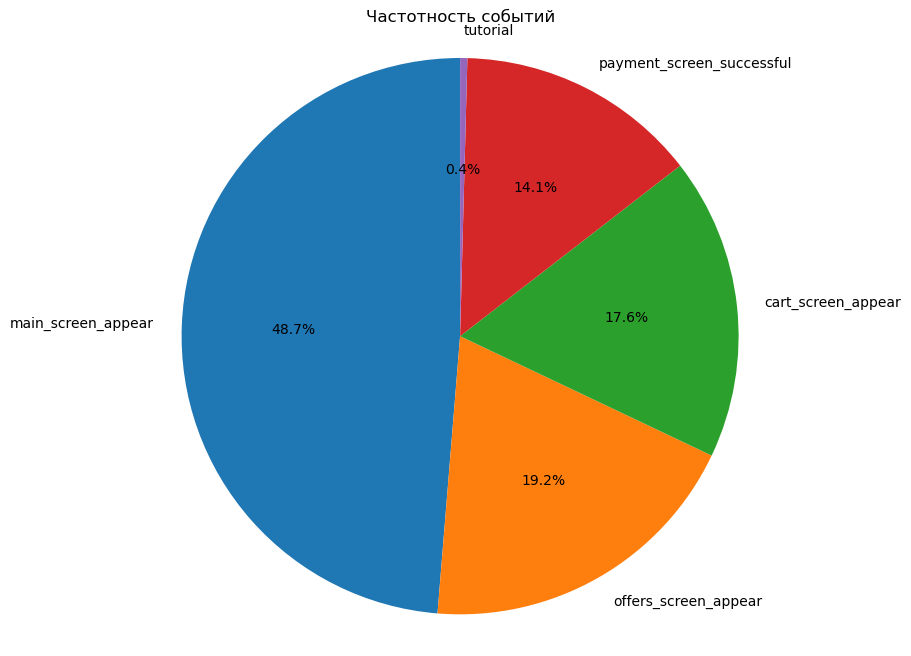

In [58]:
# готовим данные для круговой диаграммы
event_names = events_frequency['event_name']
events_number = events_frequency['events_number']

# создаём круговую диаграмму
plt.figure(figsize=(8, 8))
plt.pie(events_number, labels=event_names, autopct='%1.1f%%', startangle=90)

# задаём названия
plt.title('Частотность событий')
plt.axis('equal')  

# вывод
plt.show()

**Как было замечено в начале исследования, самое популярное событие - "Показ основного экрана" (более 117 тыс.событий, 48,7 % от всего количества событий).** 

Далее рейтинг следующий: 

2. Показ предложений - более 46 тыс. (19,2%)
3. Показ страницы с корзиной - более 42 тыс. (17,6%)
4. Показ страницы с успешной оплатой - почти 34 тыс. (14,1%)
5. Инструкции - 1 тыс. (0,4%)

Создадим функцию для подсчёта пользователей, совершивших определённое событие, в группах и их пропорции от общего количества пользователей **в этой группе**.

In [59]:
def calculate_proportion(events_data, event_name, exp_ids):
    # фильтруем данные по событию и группе
    filtered_data = events_data.query(f'event_name == "{event_name}" and exp_id.isin({exp_ids})')

    # создаём сводную таблицу
    pivot_table = filtered_data.pivot_table(index='exp_id', values='device_id_hash', aggfunc='nunique').reset_index()

    # задаём названия колонкам
    pivot_table.columns = ['exp_id', 'users_number']

    # считаем пропорции
    pivot_table['proportion'] = (
        round(pivot_table['users_number'] / (users_by_exp.query('exp_id in @exp_ids')['users_number']) * 100, 2)
    )


    return pivot_table

Проверим количество пользователей в контрольных группах для самого популярного события - просмотр главного экрана.

In [60]:
users_by_exp

,exp_id,users_number
0,246,2484
1,247,2513
2,248,2537


In [61]:
# задаём значения для функции
exp_ids = [246, 247]
event_name = "main_screen_appear"

# запуск функции
calculate_proportion(events_full, event_name, exp_ids)

,exp_id,users_number,proportion
0,246,2450,98.63
1,247,2476,98.53


**В контрольных группах 246 и 247 просмотрели главный экран 2450 и 2476 пользователей соответственно. Доля пользователей от общего количества пользователей каждой группы составила 98,63% (группа 246) и 98,53% (группа 247).** 

Сравним доли пользователей, совершивших событие. Из 2484 пользователей контрольной группы 246 просмотрели главный экран 2450 (98.63%); а из 2513 пользователей контрольной группы 247 — 2476 человек (98.53%).
Проверим, есть ли разница в пропорциях пользователей, просмотревших главную страницу, с помощью z-критерия.

In [62]:
# критический уровень статистической значимости
alpha = .05 

# совершившие событие
successes = np.array([2450, 2476])

# пользователей в каждой группе
trials = np.array([2484, 2513])

# пропорция успехов в первой группе
p1 = successes[0]/trials[0]

# пропорция успехов во второй группе
p2 = successes[1]/trials[1]

# пропорция успехов в комбинированном датасете:
p_combined = (successes[0] + successes[1]) / (trials[0] + trials[1])

# разница пропорций в датасетах
difference = p1 - p2

In [63]:
# считаем статистику в ст.отклонениях стандартного нормального распределения
z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials[0] + 1/trials[1]))

# задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
distr = st.norm(0, 1) 

In [64]:
# считаем p-value
p_value = (1 - distr.cdf(abs(z_value))) * 2

print('p-значение: ', p_value)

if p_value < alpha:
    print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными'
    )

p-значение:  0.7570597232046099
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


**p-value 0.757 (больше альфа). Мы не отвергаем нулевую гипотезу о равенстве долей пользователей, смотревших главный экран, в контрольных группах 246 и 247.**

Создаём функцию для проверки долей пользователей в контрольных группах 246 и 247, совершивших каждое событие.

Функция проверит гипотезы по каждому событию отдельно. Нулевые гипотезы для каждого события: **"Доля пользователей, совершивших событие, в группе 246 равна доле пользователей в группе 247."** 

Альтернативная гипотеза: **"Доля пользователей, совершивших событие, в группе 246 не равна доле пользователей в группе 247 (доли различны)".**

In [65]:
# создаём функцию
def perform_z_test(events_full, event_names_to_analyze, group1_id, group2_id, alpha=0.05):
    
    # создаём словарь для хранения
    results_dict = {}
    
    # считаем количество тестов
    n_tests = len(event_names_to_analyze)

    # считаем альфу с поправкой Шидака
    alpha_corrected = 1 - (1 - alpha) ** (1 / n_tests)
    
    # фильтруем данные по группе и событию
    for event_name in event_names_to_analyze:
        events_filtered = events_full.query(f'exp_id in [{group1_id}, {group2_id}] and event_name == @event_name')

        # считаем количество пользователей, совершивших событие, для каждой группы
        success_users_number_group_1 = events_filtered[events_filtered['exp_id'] == group1_id]['device_id_hash'].nunique()
        success_users_number_group_2 = events_filtered[events_filtered['exp_id'] == group2_id]['device_id_hash'].nunique()

        # считаем количество пользователей для каждой группы
        total_users_number_group_1 = events_full[events_full['exp_id'] == group1_id]['device_id_hash'].nunique()
        total_users_number_group_2 = events_full[events_full['exp_id'] == group2_id]['device_id_hash'].nunique()

        # считаем пропорции и разность
        p1 = success_users_number_group_1 / total_users_number_group_1
        p2 = success_users_number_group_2 / total_users_number_group_2
        p_combined = (success_users_number_group_1 + success_users_number_group_2) / (total_users_number_group_1 + total_users_number_group_2)
        difference = p1 - p2

        # считаем стандартное отклонение
        se = np.sqrt(p_combined * (1 - p_combined) * (1 / total_users_number_group_1 + 1 / total_users_number_group_2))

        # считаем величину z
        z_value = difference / se

        # считаем p-value
        p_value = 2 * (1 - st.norm.cdf(abs(z_value)))

        # сохраняем результат в словарь
        results_dict[event_name] = p_value

        # выводим результаты
        print(f'Событие: {event_name}')
        print('p-value:', p_value)
        print('alpha с учётом поправки Шидака: ', alpha_corrected)
        if p_value < alpha_corrected:
            print('Отклонить нулевую гипотезу: Между пропорциями есть статистически значимое различие')
        else:
            print('Невозможно отклонить нулевую гипотезу: Между пропорциями нет статистически значимых различий')
        print()


In [66]:
# определяем названия событий
event_names_to_analyze = (
    ["main_screen_appear", "offers_screen_appear", "cart_screen_appear", "payment_screen_successful", "tutorial"]
) 

In [67]:
# проводим тест для всех событий и групп 246,247
perform_z_test(events_full, event_names_to_analyze, 246, 247)

Событие: main_screen_appear
p-value: 0.7570597232046099
alpha с учётом поправки Шидака:  0.010206218313011495
Невозможно отклонить нулевую гипотезу: Между пропорциями нет статистически значимых различий

Событие: offers_screen_appear
p-value: 0.2480954578522181
alpha с учётом поправки Шидака:  0.010206218313011495
Невозможно отклонить нулевую гипотезу: Между пропорциями нет статистически значимых различий

Событие: cart_screen_appear
p-value: 0.22883372237997213
alpha с учётом поправки Шидака:  0.010206218313011495
Невозможно отклонить нулевую гипотезу: Между пропорциями нет статистически значимых различий

Событие: payment_screen_successful
p-value: 0.11456679313141849
alpha с учётом поправки Шидака:  0.010206218313011495
Невозможно отклонить нулевую гипотезу: Между пропорциями нет статистически значимых различий

Событие: tutorial
p-value: 0.9376996189257114
alpha с учётом поправки Шидака:  0.010206218313011495
Невозможно отклонить нулевую гипотезу: Между пропорциями нет статистическ

**С помощью z-критерия было определено, что p-value для всех событий выше 0.01 (альфа рассчитана с поправкой Шидака для 5 тестов), и мы не можем отклонить нулевую гипотезу о равенстве долей пользователей групп 246 и 247, совершивших каждое из следующих событий:** 

1. Показ основного экрана.
2. Показ предложений. 
3. Показ страницы с корзиной. 
4. Показ страницы с успешной оплатой.
5. Инструкции.

**Таким образом, контрольные группы равны и проведенный эксперимент даёт достоверные результаты.**

### 4.3. Проверка различий между контрольными группами и экспериментальной: с каждой по-отдельности.

Для начала посмотрим пропорции по количеству пользователей на каждое событие по группам. 
Для этого доработаем функцию для вывода пропорций сразу нескольких событий и групп.

In [68]:
def calculate_proportion(events_data, event_names, exp_ids):
    # создаём словарь для хранения результатов
    result = {}  
    
    for event_name in event_names:
       # фильтруем данные по событию и группе
        filtered_data = events_data.query(f'event_name == "{event_name}" and exp_id.isin({exp_ids})')

      # создаём сводную таблицу
        pivot_table = filtered_data.pivot_table(index='exp_id', values='device_id_hash', aggfunc='nunique').reset_index()

        # задаём названия колонок
        pivot_table.columns = ['exp_id', 'users_number']

        # считаем пропорции
        pivot_table['proportion'] = round(pivot_table['users_number'] / events_full_users_total * 100, 2)

        # добавляем результат
        result[event_name] = pivot_table
    
    return result

# задаём значения для всех событий и групп
exp_ids = [246, 247, 248]
event_names = ["main_screen_appear", "offers_screen_appear", "cart_screen_appear", "payment_screen_successful"]
results = calculate_proportion(events_full, event_names, exp_ids)

# задаём вывод отдельных таблиц для каждого события
for event_name, result_df in results.items():
    print(f"Event Name: {event_name}\n{result_df}\n")

Event Name: main_screen_appear
   exp_id  users_number  proportion
0     246          2450       32.52
1     247          2476       32.86
2     248          2493       33.09

Event Name: offers_screen_appear
   exp_id  users_number  proportion
0     246          1542       20.47
1     247          1520       20.18
2     248          1531       20.32

Event Name: cart_screen_appear
   exp_id  users_number  proportion
0     246          1266       16.80
1     247          1238       16.43
2     248          1230       16.33

Event Name: payment_screen_successful
   exp_id  users_number  proportion
0     246          1200       15.93
1     247          1158       15.37
2     248          1181       15.68



**Различия между пропорциями количества пользователей в группах для каждого события меньше 1%.** 

Дорабатываем функцию для проверки долей пользователей в трёх группах. Теперь при расчёте альфа согласно поправке Шидака учитывается 5 тестов и 3 группы.

Функция проверит гипотезы по каждому событию отдельно. 
              
Нулевые гипотезы для каждого события: **"Доля пользователей, совершивших событие, одинакова во всех трех группах (246, 247 и 248)."**

Альтернативная гипотеза: **"Доля пользователей, совершивших событие, различается по крайней мере в одной из групп (246, 247 и 248)."**        

In [69]:
# создаём функцию
def perform_z_test_multiplegroups(events_full, event_names_to_analyze, group1_id, group2_id, alpha=0.05, num_groups=3):
    
    # создаём словарь для хранения
    results_dict = {}
    
    # считаем количество тестов
    n_tests = len(event_names_to_analyze)

    # считаем альфу с поправкой Шидака
    alpha_corrected = 1 - (1 - alpha) ** (1 / (n_tests * num_groups))
    
    # фильтруем данные по группе и событию
    for event_name in event_names_to_analyze:
        events_filtered = events_full.query(f'exp_id in [{group1_id}, {group2_id}] and event_name == @event_name')

        # считаем количество пользователей, совершивших событие, для каждой группы
        success_users_number_group_1 = events_filtered[events_filtered['exp_id'] == group1_id]['device_id_hash'].nunique()
        success_users_number_group_2 = events_filtered[events_filtered['exp_id'] == group2_id]['device_id_hash'].nunique()

        # считаем количество пользователей для каждой группы
        total_users_number_group_1 = events_full[events_full['exp_id'] == group1_id]['device_id_hash'].nunique()
        total_users_number_group_2 = events_full[events_full['exp_id'] == group2_id]['device_id_hash'].nunique()

        # считаем пропорции и разность
        p1 = success_users_number_group_1 / total_users_number_group_1
        p2 = success_users_number_group_2 / total_users_number_group_2
        p_combined = (success_users_number_group_1 + success_users_number_group_2) / (total_users_number_group_1 + total_users_number_group_2)
        difference = p1 - p2

        # считаем стандартное отклонение
        se = np.sqrt(p_combined * (1 - p_combined) * (1 / total_users_number_group_1 + 1 / total_users_number_group_2))

        # считаем величину z
        z_value = difference / se

        # считаем p-value
        p_value = 2 * (1 - st.norm.cdf(abs(z_value)))

        # сохраняем результат в словарь
        results_dict[event_name] = p_value

        # выводим результаты
        print(f'Событие: {event_name}')
        print('p-value:', p_value)
        print('alpha с учётом поправки Шидака: ', alpha_corrected)
        if p_value < alpha_corrected:
            print('Отклонить нулевую гипотезу: Между пропорциями есть статистически значимое различие')
        else:
            print('Невозможно отклонить нулевую гипотезу: Между пропорциями нет статистически значимых различий')
        print()

In [70]:
# проводим тест для всех событий и групп 246,247,248
perform_z_test_multiplegroups(events_full, event_names_to_analyze, 246, 247, 248)

Событие: main_screen_appear
p-value: 0.7570597232046099
alpha с учётом поправки Шидака:  (-0.4122693186005888-0.30018711051380614j)
Невозможно отклонить нулевую гипотезу: Между пропорциями нет статистически значимых различий

Событие: offers_screen_appear
p-value: 0.2480954578522181
alpha с учётом поправки Шидака:  (-0.4122693186005888-0.30018711051380614j)
Невозможно отклонить нулевую гипотезу: Между пропорциями нет статистически значимых различий

Событие: cart_screen_appear
p-value: 0.22883372237997213
alpha с учётом поправки Шидака:  (-0.4122693186005888-0.30018711051380614j)
Невозможно отклонить нулевую гипотезу: Между пропорциями нет статистически значимых различий

Событие: payment_screen_successful
p-value: 0.11456679313141849
alpha с учётом поправки Шидака:  (-0.4122693186005888-0.30018711051380614j)
Невозможно отклонить нулевую гипотезу: Между пропорциями нет статистически значимых различий

Событие: tutorial
p-value: 0.9376996189257114
alpha с учётом поправки Шидака:  (-0.41

**С помощью z-критерия было определено, что p-value для всех событий и трёх сравниваемых групп выше альфа (альфа рассчитана с поправкой Шидака для 5 тестов и 3 групп), и мы не можем отклонить нулевую гипотезу.  Доля пользователей, совершивших каждое событие, одинакова во всех трех группах (246, 247 и 248).**

**Получается, что поведение пользователей не изменилось, когда они использовали интерфейс приложения с новым шрифтом.**

### 4.4. Проверка различий между контрольными группами и экспериментальной: с двумя контрольными группами вместе.

Сравним пропорции пользователей, совершивших событие, в экспериментальной группе 248 с пользователями объединённых контрольных групп: объединим совершенные пользователями события из групп 246 и 247, назовём эту объединённую группу 250.

Для начала посчитаем пропорции для кажого события и группы, затем проверим гипотезы.

Нулевая гипотеза для каждого события: **"Пропорция пользователей, совершивших событие, в объединённой контрольной группе 250 равна пропорции в экспериментальной группе 248."** 

Альтернативная гипотеза: **"Пропорция пользователей, совершивших событие, в объединённой контрольной группе 250 не равна пропорции пользователей в экспериментальной группе 248 (пропорции пользователей различны)".**

In [71]:
# задаём один номер для обеих контрольных групп
events_full_246_plus_247 = events_full
events_full_246_plus_247['exp_id'] = events_full_246_plus_247['exp_id'].replace([246,247], 250)

# задаём значения для всех событий и групп
exp_ids = [250, 248]

In [72]:
perform_z_test(events_full_246_plus_247, event_names_to_analyze, 250, 248)

Событие: main_screen_appear
p-value: 0.29424526837179577
alpha с учётом поправки Шидака:  0.010206218313011495
Невозможно отклонить нулевую гипотезу: Между пропорциями нет статистически значимых различий

Событие: offers_screen_appear
p-value: 0.43425549655188256
alpha с учётом поправки Шидака:  0.010206218313011495
Невозможно отклонить нулевую гипотезу: Между пропорциями нет статистически значимых различий

Событие: cart_screen_appear
p-value: 0.18175875284404386
alpha с учётом поправки Шидака:  0.010206218313011495
Невозможно отклонить нулевую гипотезу: Между пропорциями нет статистически значимых различий

Событие: payment_screen_successful
p-value: 0.6004294282308704
alpha с учётом поправки Шидака:  0.010206218313011495
Невозможно отклонить нулевую гипотезу: Между пропорциями нет статистически значимых различий

Событие: tutorial
p-value: 0.764862472531507
alpha с учётом поправки Шидака:  0.010206218313011495
Невозможно отклонить нулевую гипотезу: Между пропорциями нет статистическ

**С помощью z-критерия было определено, что p-value для всех событий выше 0.01 (альфа рассчитана с поправкой Шидака для 5 тестов), и мы не можем отклонить нулевую гипотезу о равенстве долей пользователей объединенных контрольных групп 246 и 247 с долями экспериментальной группы 248 по всем событиям.**

**Это ещё раз доказывает, что поведение пользователей при замене шрифта не изменилось.**

<div style="border:solid Chocolate 2px; padding: 40px">

## Общий вывод.

#### Предобработка данных. 

На этапе предобработки не выявлено пропусков, удалены дубликаты, скорректированы заголовки столбцов согласно pep8, столбец с датой и временем приведён к формату datetime, добавлен столбец с датой отдельно.

#### Изучение данных. 
Всего в логе 243 713 событий и 7 551 пользователь.  Медианное количество событий на пользователя - 20.

Выявлено, что по факту до 1 августа 2019 года данных почти нет. Поэтому было принято решение оценивать результаты теста по данным с 1 августа. Был создан новый датасет с периодом проведения экспериментов 1-7 августа 2019 года. В датасете более 240 тыс. событий и более 7,5 тыс. пользователей. При удалении данных за период 25-31 июля 2019 года было утеряно 1,16% событий и 0,23% пользователей, что незначительно для корретной интерпретации экспериментов.

В группах эксперимента достаточное количество пользователей (около 2500 пользователей в каждой).

#### Анализ воронки событий.
Рейтинг событий по их количеству и по количеству пользователей, совершивших событие, совпал: 

1. Показ основного экрана 
2. Показ предложений 
3. Показ страницы с корзиной 
4. Показ страницы с успешной оплатой 
5. Инструкции 


Выстроена следующая воронка событий для пользователя (с указанием количества пользователей на каждом шаге): 

1. Показ основного экрана - более 7 тыс.
2. Показ предложений - более 4,5 тыс.
3. Показ страницы с корзиной - более 3,7 тыс.
4. Показ страницы с успешной оплатой - почти 3,5 тыс.

Больше всего пользователей потеряли на шаге "Показ предложений" (около 40%). 

На шаге "Показ страницы с корзиной" осталось 80% пользователей с предыдущего шага "Показ предложений", а на шаге "Показ страницы с успешной оплатой" осталось 90% пользователей, которые были на предыдущем шаге "Показ страницы с корзиной".

Доля пользователей, которые доходят от первого события до оплаты, от всех пользователей, которые двигались по воронке событий, составляет 46%. 


####  Анализ А/А/В-теста.

- количество пользователей в группах 246, 247, 248 около 2 500 человек (в каждой);
- проведены t-тесты для сравнения средних по количеству пользователей и количеству мероприятий между контрольными группами (246 и 247) и между контрольной и экспериментальной группой (246 и 248). По результатам всех тестов, нулевые гипотезы о равенстве средних не отвергнуты. Это означает, что данные собраны корректно и на их основании можно сделать точный вывод о результатах эксперимента;
- проведена проверка на "пересекающихся" пользователей: в выборках нет пользователей, которые вошли в несколько групп одновременно. Это означает, что на их выбор событий влиял только один показанный шрифт;
- самое популярное событие - "Показ основного экрана", что понятно, так как все заходят сначала на главную страницу.
В контрольных группах 246 и 247 просмотрели главный экран 98,63% (группа 246) и 98,53% (группа 247);
- с помощью z-критерия было определено, что p-value для всех событий выше альфа (альфа рассчитана с поправкой Шидака с учётом количества тестов и групп, где необходимо), и мы не можем отклонить следующие нулевые гипотезы: 
  - доли пользователей, совершивших событие, в группах 246 и 247 равны;
  - доля пользователей, совершивших каждое событие, одинакова во всех трех группах (246, 247 и 248);
  - доли пользователей объединенных контрольных групп 246 и 247 равны с долями пользователей экспериментальной группы 248 по всем событиям.

**Таким образом:**
    
**- контрольные группы равны и проведенный эксперимент даёт достоверные результаты;**
    
**- поведение пользователей не изменилось, когда они использовали интерфейс приложения с новым шрифтом.**

### Основные выводы и рекомендации:

 - Было выявлено, что 40% пользователей уходит из приложения после шага "Просмотр основного экрана" и уже не попадает на шаг "Просмотр предложений". Необходимо провести дополнительное исследование, чтобы понять, что отталкивает пользователей на этом шаге и что может увеличить процент перехода пользователей на второй шаг. 
 
 - Согласно проведённым статистическим тестам пользователи, которые видели старый шрифт, и пользователи, которые видели новый шрифт в мобильном приложении, двигаются по воронке событий одинаково. Рекомендуется остановить тест с заключением: "Новый шрифт не повлиял на поведение пользователей приложения негативно, и его можно использовать."